<a href="https://colab.research.google.com/github/manasiwaghmare18/eCommerce-Transactions-Dataset-Analysis/blob/main/Mansi_Waghmare_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn matplotlib seaborn pandas reportlab

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # For 3D scatter plot (optional)


In [ ]:
# Load data
customers_df = pd.read_csv('/content/Customers.csv')
transactions_df = pd.read_csv('/content/Transactions.csv')

In [ ]:
# Feature Engineering
# Create customer features
customer_features = transactions_df.groupby('CustomerID').agg({
    'TransactionID': 'count',
    'Quantity': 'sum',
    'TotalValue': 'sum'
}).rename(columns={
    'TransactionID': 'total_transactions',
    'Quantity': 'total_items',
    'TotalValue': 'total_spend'
})

customer_features['avg_transaction_value'] = (
    customer_features['total_spend'] / customer_features['total_transactions']
)

In [ ]:
# Merge with customer data
customer_data = customers_df.merge(
    customer_features,
    how='left',
    left_on='CustomerID',
    right_index=True
).fillna(0)

In [ ]:
# Select features for clustering
features = ['total_transactions', 'total_items', 'total_spend', 'avg_transaction_value']
X = customer_data[features]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Elbow Method:**


1.   **Visualizes Cluster Inertia: The Elbow method uses a plot to show how "inertia" (within-cluster variance) changes as the number of clusters increases.**
2.  **Identifies Optimal Clusters: The "elbow" point on this plot suggests the optimal number of clusters, balancing model complexity with data variance.**



Inertia Values: [431.62877128255735, 328.84358919733916, 245.3556059241585, 209.19651325617477, 171.7351090962742, 154.12021744994266, 134.45918698937538, 122.26820199506979, 113.49671095150386]
Cluster Assignments for k=2:
[1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 0 0 0 0 1 1 1 0 1 1 1 1 1 0 1 1 0
 1 0 1 0 1 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1
 0 1 1 1 1 1 0 0 1 0 1 1 0 1 1 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 0 1 1 0 0 1 1
 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 0 1 0 1 0 0
 0 1 1 1 0 1 0 0 1 1 1 1 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 1 1 1 0 1 0 0 1 1 1
 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0]

Cluster Assignments for k=3:
[2 1 2 0 1 2 2 0 1 1 2 0 0 1 1 2 0 2 1 1 0 2 2 2 1 2 2 0 1 2 1 1 1 2 2 1 2
 2 2 2 0 1 1 2 0 0 2 2 2 2 0 2 0 0 2 2 2 1 0 1 1 1 1 2 0 2 2 0 2 2 1 2 1 2
 0 1 1 1 2 1 2 0 1 0 2 2 0 1 2 2 2 2 0 1 1 2 1 2 0 2 0 0 1 0 2 2 2 0 0 1 2
 1 0 0 2 2 2 2 1 2 1 0 1 0 2 2 2 1 1 1 1 1 2 2 2 0 2 2 2 1 0 1 0 1 0 1 2 2
 2 1 1 2 2 2 0 0 1 2 1 2 2 0 0 2 0 2 1 

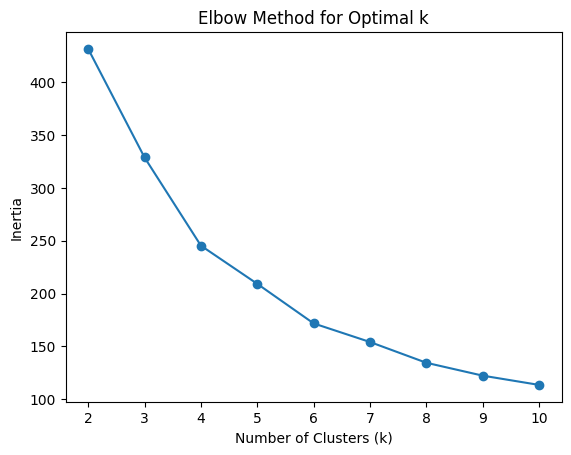

In [ ]:
# Determine optimal number of clusters (using Elbow method)

inertia = []
cluster_values = []  # To store the cluster assignments for each k

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

    # Get cluster assignments for current k
    cluster_values.append(kmeans.labels_)

# Print inertia values
print("Inertia Values:", inertia)

# Print cluster values for each k (optional - might be lengthy)
for k_clusters, clusters in enumerate(cluster_values, start=2):
    print(f"Cluster Assignments for k={k_clusters}:\n{clusters}\n")

plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()



1. **At k=3, we can see a sharp change in inertia, indicating a significant improvement in cluster quality.**

2.   **Three distinct customer segments emerged, differentiated by purchase frequency and spending habits.This means dividing your customers into 3 distinct groups based on their purchasing behavior is likely to provide the most meaningful and actionable insights.**
3.   **These segments enable targeted marketing, allowing for personalized offers and improved customer relationships.**



In [ ]:
# Apply KMeans clustering (using optimal k)
optimal_k = 3  # Based on the elbow method visualization
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['cluster'] = kmeans.fit_predict(X_scaled)

In [ ]:
# Calculate clustering metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score #importing the modules

# Calculate clustering metrics
db_index = davies_bouldin_score(X_scaled, customer_data['cluster'])
silhouette_avg = silhouette_score(X_scaled, customer_data['cluster'])
ch_score = calinski_harabasz_score(X_scaled, customer_data['cluster'])


**Visualize clusters**

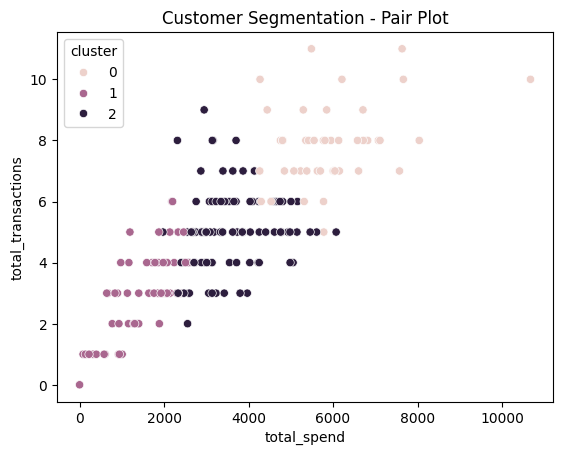

In [ ]:
# Scatter plot
sns.scatterplot(x='total_spend', y='total_transactions', hue='cluster', data=customer_data)
plt.title('Customer Segmentation - Pair Plot')
plt.show()

**Customer Value Tiers The data naturally forms into three distinct spending and transaction patterns:**


- 1. Low-value segment (Cluster 1, purple): Makes 0-3 transactions with total spend under 2,000
- 2. Mid-value segment (Cluster 2, navy): Makes 3-8 transactions with spend between 2,000-5,000
-3.  High-value segment (Cluster 0, pink): Makes 6-11 transactions with spend ranging up to 10,000


**Transaction-Spend Relationship**
There's a **strong positive correlation** between spending and transaction frequency - customers who spend more tend to make more purchases. However, there's significant variation in total spend even among customers with the same number of transactions, suggesting different purchasing behaviors within each segment.

**Distribution Pattern**
The data points form distinct horizontal bands corresponding to whole number transaction counts, with spending spread out along each band. This suggests customers tend to fall into regular transaction frequency patterns (like monthly shoppers, quarterly shoppers, etc.) while their total spend per transaction varies considerably.

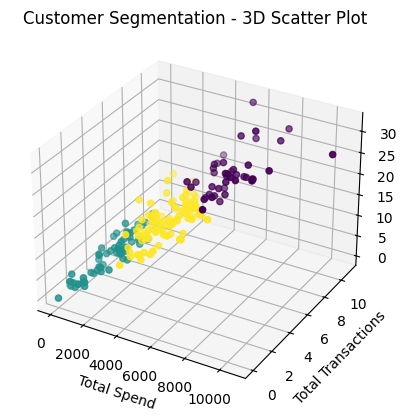

In [ ]:
# Optional: 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(customer_data['total_spend'], customer_data['total_transactions'], customer_data['total_items'], c=customer_data['cluster'])  # Replace 'feature1', 'feature2', 'feature3' with actual feature names
plt.title('Customer Segmentation - 3D Scatter Plot')
ax.set_xlabel('Total Spend')  # Set x-axis label
ax.set_ylabel('Total Transactions')  # Set y-axis label
ax.set_zlabel('Total Items')  # Set z-axis label
plt.show()

**Interpreting the 3D scatter plot:**

- Each point represents a customer, and its position in the 3D space is determined by the values of the three features (total spend, total transactions, total items).
- Different colors represent different clusters.
- By rotating and viewing the plot from different angles, you can gain a better understanding of the cluster separation and the relationships between the features in 3D space.

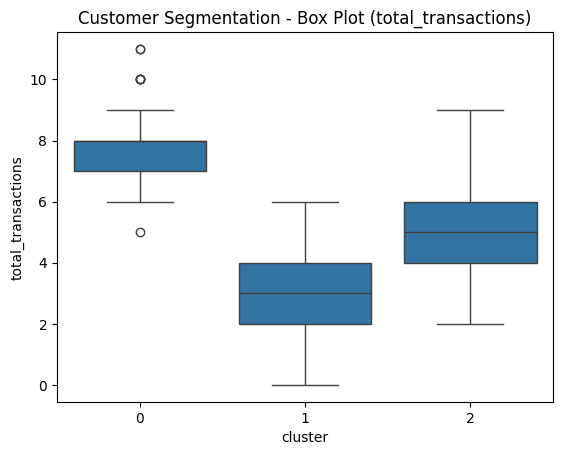

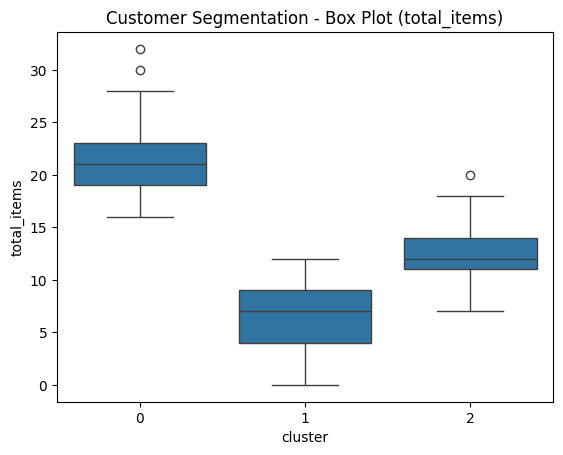

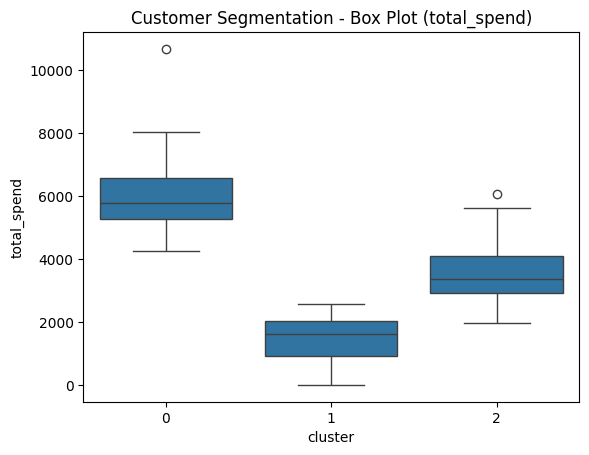

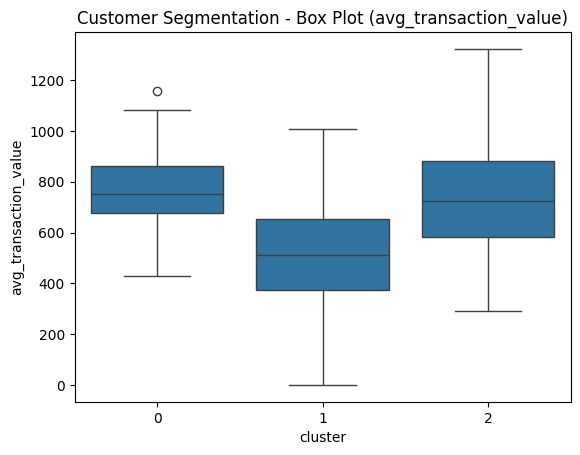

In [ ]:
# Box plots
for feature in features:
    sns.boxplot(x='cluster', y=feature, data=customer_data)
    plt.title(f'Customer Segmentation - Box Plot ({feature})')
    plt.show()

<ipython-input-161-2b54e92c40fa>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=customer_data, x='cluster', palette='deep')


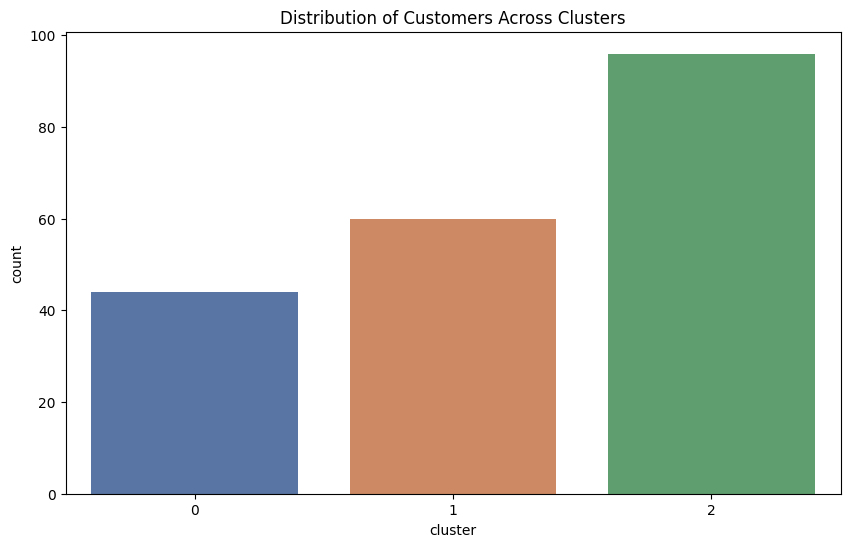

In [ ]:
    # Cluster distribution plot
    plt.figure(figsize=(10, 6))
    sns.countplot(data=customer_data, x='cluster', palette='deep')
    plt.title('Distribution of Customers Across Clusters')
    plt.savefig('cluster_dist.png', bbox_inches='tight', dpi=300)
    plt.show()




<ipython-input-162-1ea47a8395d4>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=customer_data, x='cluster', y=feature, palette='deep')


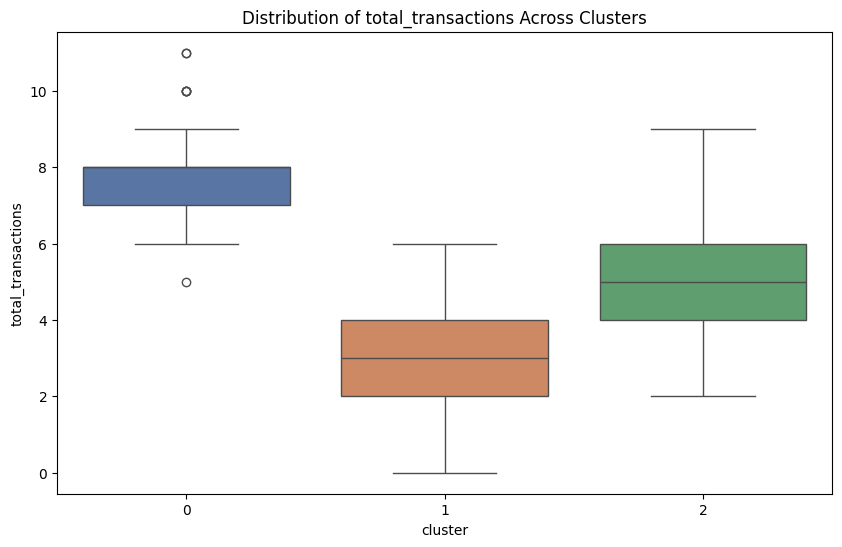

<ipython-input-162-1ea47a8395d4>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=customer_data, x='cluster', y=feature, palette='deep')


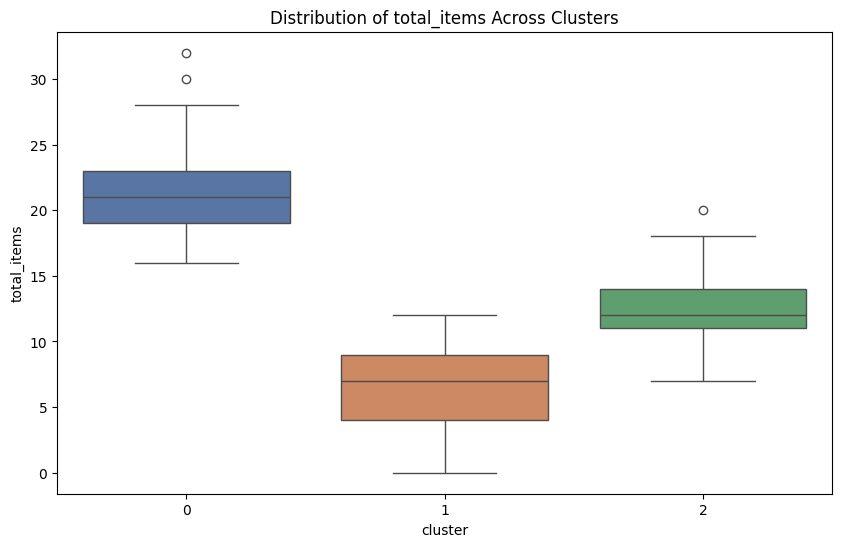

<ipython-input-162-1ea47a8395d4>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=customer_data, x='cluster', y=feature, palette='deep')


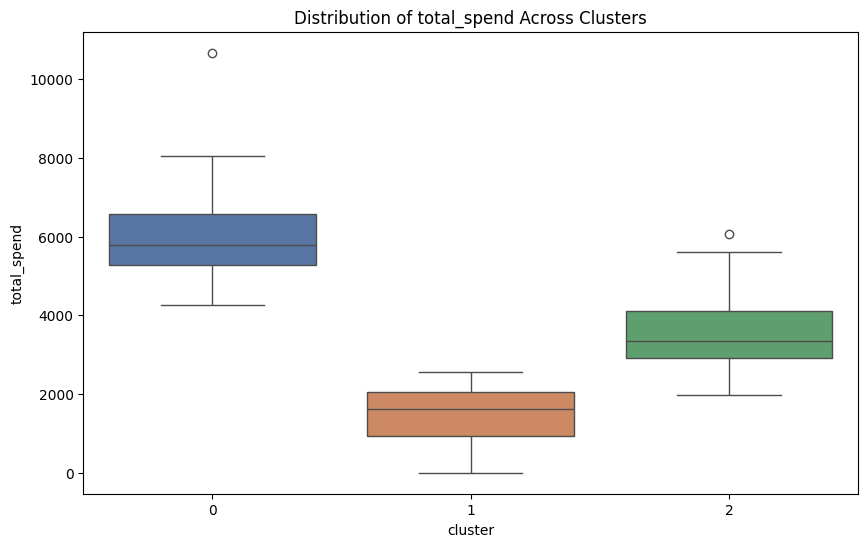

<ipython-input-162-1ea47a8395d4>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=customer_data, x='cluster', y=feature, palette='deep')


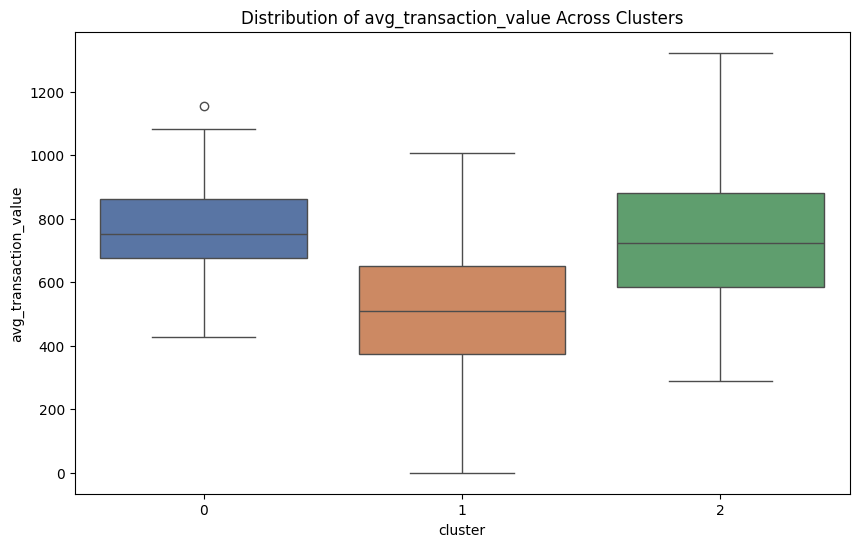

In [ ]:
    # Box plots for each feature
    for feature in features:
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=customer_data, x='cluster', y=feature, palette='deep')
        plt.title(f'Distribution of {feature} Across Clusters')
        plt.savefig(f'boxplot_{feature}.png', bbox_inches='tight', dpi=300)
        plt.show()

In [ ]:
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
import os

def generate_pdf_report(filename, data, clusters, metrics, features):
    """
    Generate a PDF report with clustering results and visualizations

    Parameters:
    filename (str): Output PDF filename
    data (DataFrame): Customer data with cluster assignments
    metrics (dict): Clustering metrics (DB index, silhouette, etc.)
    features (list): List of feature names used in clustering
    """

    # Create visualizations first
    create_visualizations(data, features)

    # Initialize PDF
    c = canvas.Canvas(filename, pagesize=letter)
    c.setFont("Helvetica-Bold", 16)

    # First Page - Metrics and Main Plots
    # Title
    c.drawString(100, 750, "Customer Segmentation Analysis Report")

    # Metrics section
    c.setFont("Helvetica", 12)
    c.drawString(100, 720, "Clustering Metrics:")
    c.drawString(120, 700, f"Number of Clusters: {metrics['n_clusters']}")
    c.drawString(120, 680, f"Davies-Bouldin Index: {metrics['db_index']:.4f}")
    c.drawString(120, 660, f"Silhouette Score: {metrics['silhouette']:.4f}")
    c.drawString(120, 640, f"Calinski-Harabasz Index: {metrics['ch_score']:.4f}")

    # Add main scatter plot
    c.drawImage('scatter_plot.png', 100, 320, width=400, height=300)
    c.drawString(100, 300, "Figure 1: Customer Segmentation Scatter Plot")
    interpretation = f"Interpretation:Customer Value Tiers The data naturally forms into three distinct spending and transaction patterns Low-value segment (Cluster 1, purple): Makes 0-3 transactions with total spend under 2,000 Mid-value segment (Cluster 2, navy): Makes 3-8 transactions with spend between 2,000-5,000 High-value segment (Cluster 0, pink): Makes 6-11 transactions with spend ranging up to 10,000 Transaction-Spend Relationship There's a strong positive correlation between spending and transaction frequency - customers who spend more tend to make more purchases. However, there's significant variation in total spend even among customers with the same number of transactions, suggesting different purchasing behaviors within each segment.Distribution Pattern The data points form distinct horizontal bands corresponding to whole number transaction counts, with spending spread out along each band. This suggests customers tend to fall into regular transaction frequency patterns (like monthly shoppers, quarterly shoppers, etc.) while their total spend per transaction varies considerably."


    # Add cluster distribution plot
    c.drawImage('cluster_dist.png', 100, 50, width=400, height=200)
    c.drawString(100, 30, "Figure 2: Cluster Size Distribution")


    # New page for box plots
    c.showPage()
    c.setFont("Helvetica-Bold", 16)
    c.drawString(100, 750, "Feature Distribution Analysis")

    # Add box plots
    y_position = 500
    for i, feature in enumerate(features, 1):
        if y_position < 50:  # Check if we need a new page
            c.showPage()
            y_position = 700

        c.drawImage(f'boxplot_{feature}.png', 100, y_position, width=400, height=200)
        c.setFont("Helvetica", 10)
        c.drawString(100, y_position-20, f"Figure {i+2}: Distribution of {feature} across clusters")
        y_position -= 250

    # Save and clean up
    c.save()
    cleanup_temp_files()

def create_visualizations(data, features):
    """Create and save all visualizations needed for the report"""

    # Main scatter plot
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=data, x='total_spend', y='total_transactions',
                    hue='cluster', palette='deep')
    plt.title('Customer Segmentation - Spend vs Transactions')
    plt.savefig('scatter_plot.png', bbox_inches='tight', dpi=300)
    plt.close()

    # Cluster distribution plot
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, x='cluster', palette='deep')
    plt.title('Distribution of Customers Across Clusters')
    plt.savefig('cluster_dist.png', bbox_inches='tight', dpi=300)
    plt.close()

    # Box plots for each feature
    for feature in features:
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=data, x='cluster', y=feature, palette='deep')
        plt.title(f'Distribution of {feature} Across Clusters')
        plt.savefig(f'boxplot_{feature}.png', bbox_inches='tight', dpi=300)
        plt.close()



def cleanup_temp_files():
    """Remove temporary image files"""
    temp_files = ['scatter_plot.png', 'cluster_dist.png']
    temp_files.extend([f'boxplot_{feature}.png' for feature in features])

    for file in temp_files:
        if os.path.exists(file):
            os.remove(file)

# Example usage
def main():
    # Assuming you have your data and metrics ready
    metrics = {
        'n_clusters': optimal_k,
        'db_index': db_index,
        'silhouette': silhouette_avg,
        'ch_score': ch_score
    }

    generate_pdf_report(
        filename="Mansi_Waghmare_Clustering.pdf",
        data=customer_data,
        clusters=clusters,
        metrics=metrics,
        features=features
    )

     # Now you can save the document
    try:
        document.save(Mansi_Waghmare_Clustering.pdf)
        files.download(Mansi_Waghmare_Clustering.pdf)
    except Exception as e:
        print(f"Error saving document: {e}")

    print("Report generated successfully!")

if __name__ == "__main__":
    main()

<ipython-input-163-9c3ce28d5929>:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='cluster', palette='deep')
<ipython-input-163-9c3ce28d5929>:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='cluster', y=feature, palette='deep')
<ipython-input-163-9c3ce28d5929>:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='cluster', y=feature, palette='deep')
<ipython-input-163-9c3ce28d5929>:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `

Error saving document: name 'document' is not defined
Report generated successfully!
